<a href="https://colab.research.google.com/github/ManikantaPinabakala/slashMarkProject5/blob/main/SlashMark_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download sachinkumar413/diabetic-retinopathy-dataset

 94% 329M/350M [00:02<00:00, 134MB/s]
100% 350M/350M [00:02<00:00, 139MB/s]


In [ ]:
!unzip diabetic-retinopathy-dataset.zip

# Importing all the libraries required.

In [6]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
All done


# Importing data

In [9]:
data = os.listdir('/content/diabetic-retinopathy-dataset')

Healthy = os.listdir('/content/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/content/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/content/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/content/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/content/diabetic-retinopathy-dataset/Severe DR')

In [10]:
print("Classes:", (data), "\n______________________________\n")
print("Number of classes:", len(data), "\n______________________________\n")
print("Number of Healty images:", len(Healthy), "\n______________________________\n")
print("Number of Mild images:", len(Mild),  "\n______________________________\n")
print("Number of Moderate images:", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images:", len(Proliferate),  "\n______________________________\n")
print("Number of Severe images:", len(Severe),  "\n______________________________\n")

Classes: ['Proliferate DR', 'Healthy', 'Mild DR', 'Moderate DR', 'Severe DR'] 
______________________________

Number of classes: 5 
______________________________

Number of Healty images: 1000 
______________________________

Number of Mild images: 370 
______________________________

Number of Moderate images: 900 
______________________________

Number of Proliferate images: 290 
______________________________

Number of Severe images: 190 
______________________________



Here, we can see that the data is imbalanced.

In [12]:
# Get dataset path
Path_data = '/content/diabetic-retinopathy-dataset'

# Create two lists to store paths of images and their labels
img_paths = []
labels =[]

# Convert directory to list
data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data
for i in data:
  class_path = os.path.join(Path_data, i)
  img_list = os.listdir(class_path)

  for img in img_list:
    img_path = os.path.join(class_path, img)

    img_paths.append(img_path)
    labels.append(i)


# Convert two lists of imgpaths and their labels into series
Paths = pd.Series(img_paths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called df
df= pd.concat([Paths, Labels], axis = 1)
df.head()

,Paths,Labels
0,/content/diabetic-retinopathy-dataset/Prolifer...,Proliferate DR
1,/content/diabetic-retinopathy-dataset/Prolifer...,Proliferate DR
2,/content/diabetic-retinopathy-dataset/Prolifer...,Proliferate DR
3,/content/diabetic-retinopathy-dataset/Prolifer...,Proliferate DR
4,/content/diabetic-retinopathy-dataset/Prolifer...,Proliferate DR


# About Diabetic Retinopathy

**Diabetic retinopathy is a complication of diabetes and a leading cause of blindness. It occurs when diabetes damages the tiny blood vessels inside the retina, the light-sensitive tissue at the back of the eye. A healthy retina is necessary for good vision.**
<br /><br />

*If you have diabetic retinopathy, at first you may notice no changes to your vision. But over time, diabetic retinopathy can get worse and cause vision loss. Diabetic retinopathy usually affects both eyes.*
<br /><br />

<u>**Diabetic Retinopathy has four stages:**</u>
<br /><br />

<u>***1. Mild Nonproliferative Retinopathy:***</u>

At this earliest stage, microaneurysms occur. They are small areas of balloon-like swelling in the retina’s tiny blood vessels.

<u>***2. Moderate Nonproliferative Retinopathy:***</u>

As the disease progresses, some blood vessels that nourish the retina are blocked.

<u>***3. Severe Nonproliferative Retinopathy:***</u>

Many more blood vessels are blocked, depriving several areas of the retina with their blood supply. These areas of the retina send signals to the body to grow new blood vessels for nourishment.

<u>***4. Proliferative Retinopathy:***</u>

At this advanced stage, the signals sent by the retina for nourishment trigger the growth of new blood vessels. These new blood vessels are abnormal and fragile. They grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.

By themselves, these blood vessels do not cause symptoms or vision loss. However, they have thin, fragile walls. If they leak blood, severe vision loss and even blindness can result.

# Split data into train, valid, test datasets

In [16]:
# Train, valid  and test dataframes
train, testval = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ", test.shape)

print()

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)



Healthy           802
Moderate DR       723
Mild DR           292
Proliferate DR    232
Severe DR         151
Name: Labels, dtype: int64

# Data Augmentation

In [17]:
batch_size = 20
img_size = (224, 224) # Standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#Create generators
tr_G = ImageDataGenerator(
  zca_whitening=True,
  rotation_range=30.,
  fill_mode='nearest',
)

V_G = ImageDataGenerator()
t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model
Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


# Representing a sample

{'Healthy': 0, 'Mild DR': 1, 'Moderate DR': 2, 'Proliferate DR': 3, 'Severe DR': 4}
['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']


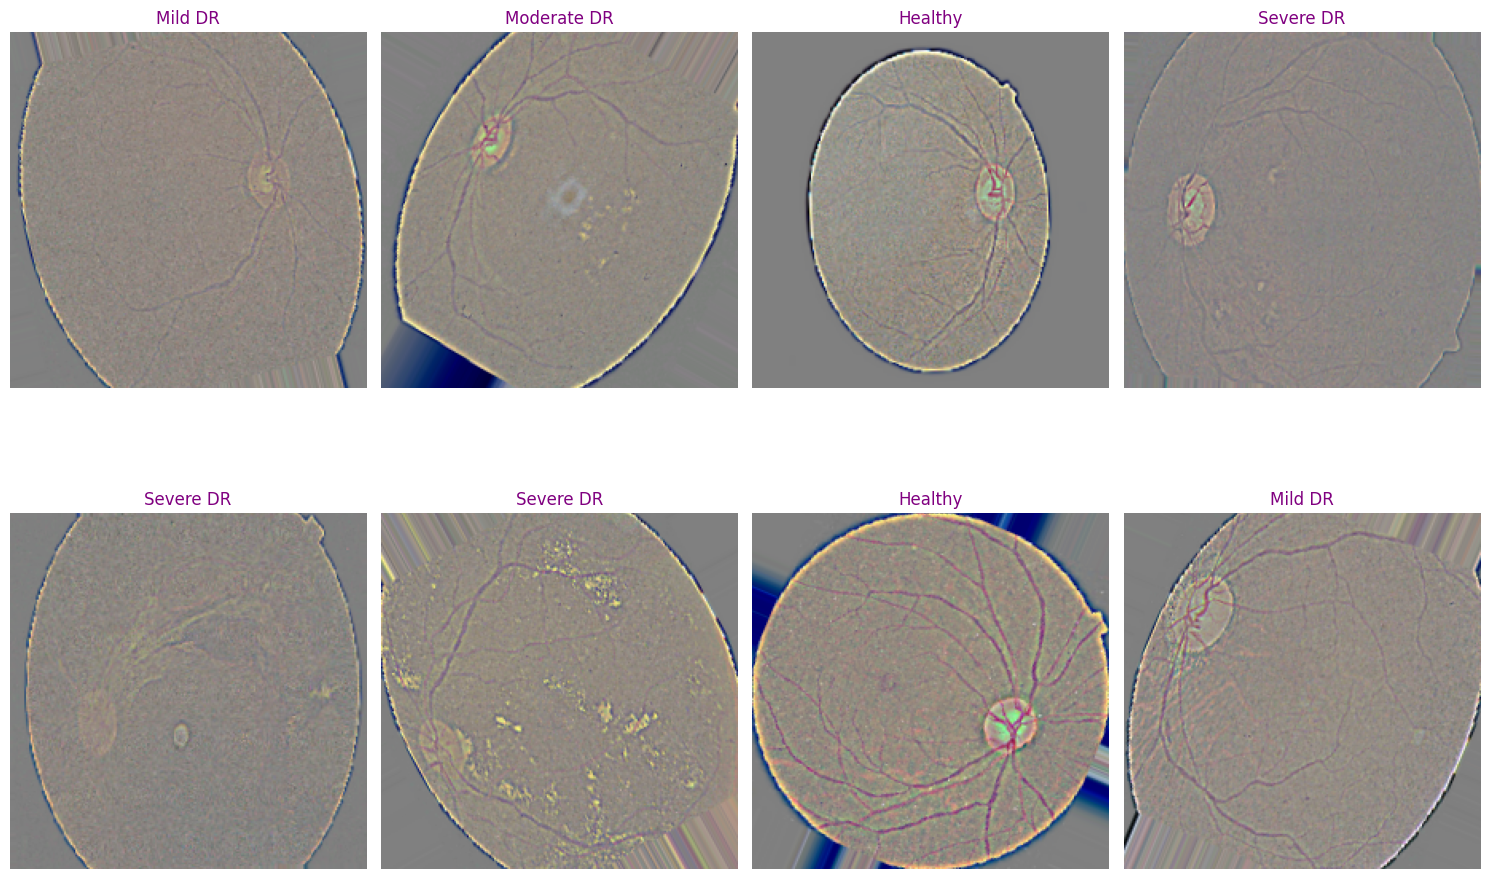

In [18]:
# Define labels and their indices as a dict
L_index = Train.class_indices
print(L_index)

# Store Labels in a list
Keys = list(L_index.keys())
print(Keys)

#Get a sample batch
imgs, labels = next(Train)

# Visualization of samples
plt.figure(figsize= (15, 15))

for i in range(8):
  plt.subplot(3, 4, i +1)
  im = imgs[i]/255
  plt.imshow(im)

  #Labelling
  index = np.argmax(labels[i])
  label = Keys[index]
  plt.title(label, color = 'purple')
  plt.axis('off')

plt.tight_layout()
plt.show()

# Modeling

<h3>A. Creating a model using transfer learning with EfficientNetB2</h3>

In [19]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
print(n_classes)

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)

x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)

x=Dropout(rate=.2, seed=123)(x)

x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)

x=Dropout(rate=.3, seed=123)(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)

x=Dropout(rate=.4, seed=123)(x)

output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # Starting with this learning rate

5
43941136/43941136 [==============================] - 0s 0us/step


In [20]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [21]:
model.compile(
  Adamax(learning_rate=0.0001),
  loss='categorical_crossentropy',
  metrics=['acc']
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                        

<h3>B. Visualizing model layers</h3>

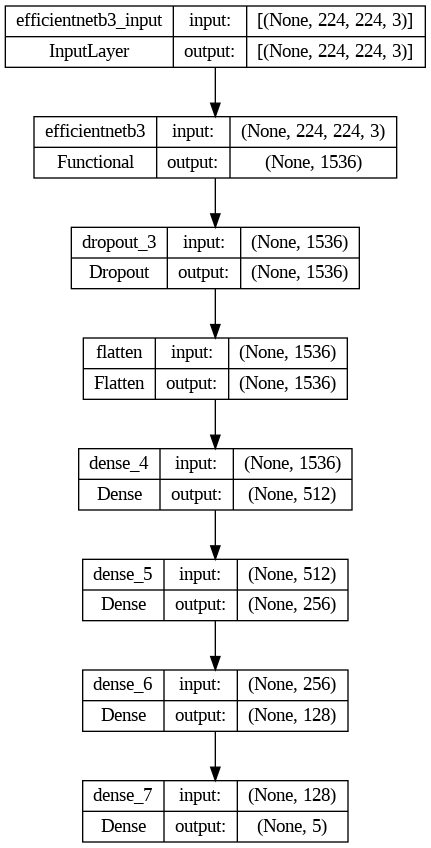

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

<h3>C. Training Phase</h3>

In [24]:
epochs = 50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid,
                    validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 106s 464ms/step - loss: 1.6532 - acc: 0.4968 - val_loss: 1.9019 - val_acc: 0.3818
Epoch 2/50
110/110 [==============================] - 44s 401ms/step - loss: 1.2357 - acc: 0.5618 - val_loss: 1.2389 - val_acc: 0.5418
Epoch 3/50
110/110 [==============================] - 45s 404ms/step - loss: 1.1191 - acc: 0.5936 - val_loss: 1.0809 - val_acc: 0.6218
Epoch 4/50
110/110 [==============================] - 45s 405ms/step - loss: 1.0124 - acc: 0.6327 - val_loss: 0.9924 - val_acc: 0.6509
Epoch 5/50
110/110 [==============================] - 45s 406ms/step - loss: 0.9359 - acc: 0.6436 - val_loss: 0.9433 - val_acc: 0.6691
Epoch 6/50
110/110 [==============================] - 44s 402ms/step - loss: 0.9022 - acc: 0.6645 - val_loss: 0.9089 - val_acc: 0.6873
Epoch 7/50
110/110 [==============================] - 45s 405ms/step - loss: 0.8246 - acc: 0.6859 - val_loss: 0.8584 - val_acc: 0.6909
Epoch 8/50
110/110 [==============================] - 

<h3>D. Evaluation</h3>

In [27]:
# Accuracy and loss of Train
tr_acc = history.history['acc']
tr_loss = history.history['loss']

# accuracy and loss or Valid\
v_acc = history.history['val_acc']
v_loss = history.history['val_loss']

# Highest value of v_acc by getting its index
index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]

# Lowest value of v_loss by getting index
index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

# Number of epochs based on length of tr_acc values
Epochs =[]
for i in range(len(tr_acc)):
  Epochs.append (i+1)


# Define best epoch
best_acc = f'Best epoch accuracy = {str(index_acc +1)}'
best_loss = f'Best epoch loss = {str(index_loss+1)}'

print(best_acc)
print(best_loss)

Best epoch accuracy = 48
Best epoch loss = 16


<h3>E. Visualizing the best Epoch</h3>

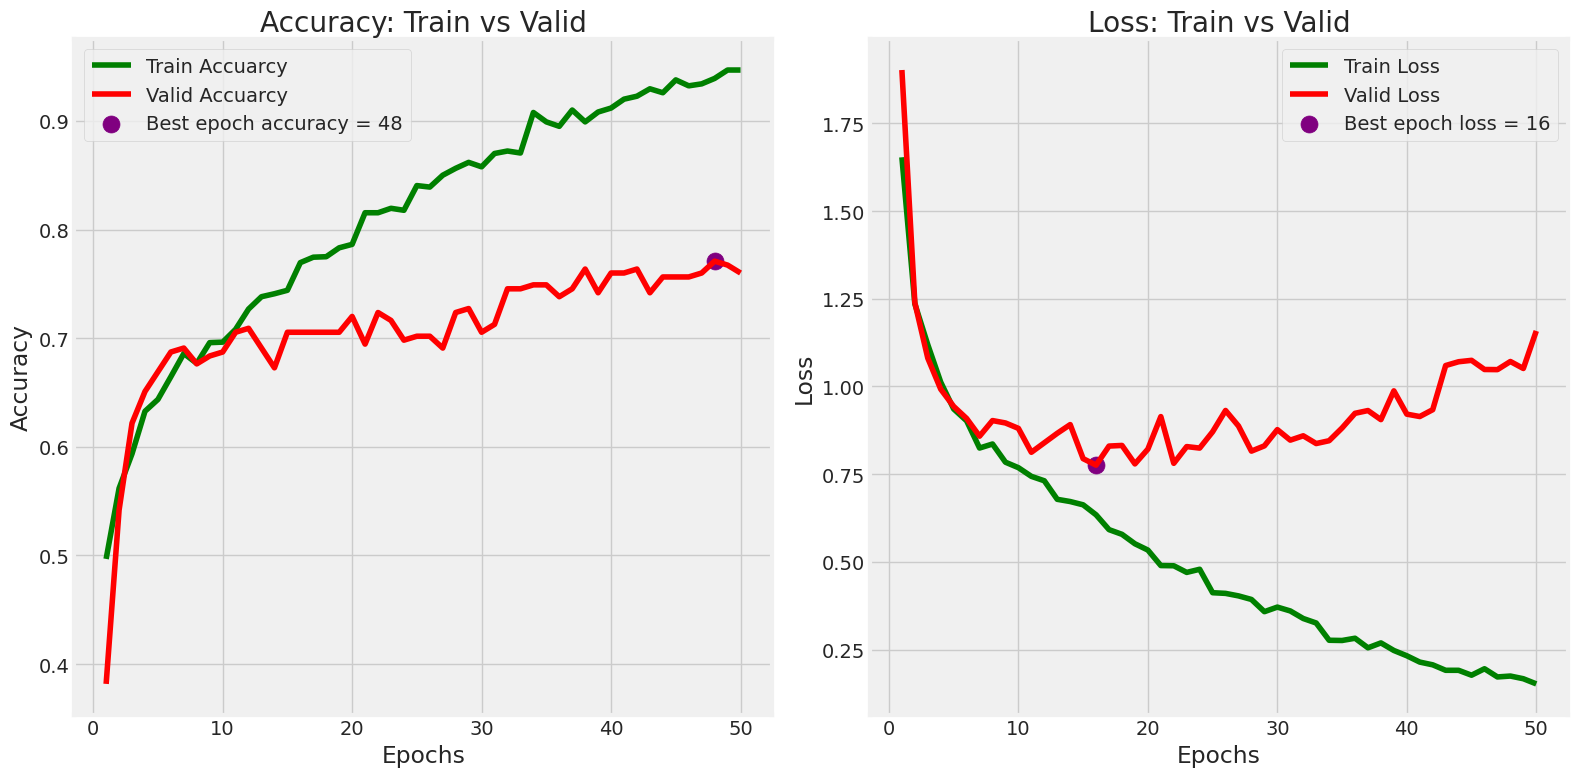

In [28]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')

# Subplot 1 for best epoch accuracy
plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s = 150, color = 'purple', label = best_acc)
plt.title("Accuracy: Train vs Valid")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot2 for best epoch loss
plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s = 150, color = 'purple', label = best_loss)
plt.title("Loss: Train vs Valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Evaluation scores
Train_scores = model.evaluate(Train, verbose = 1)
Valid_scores = model.evaluate(Valid, verbose = 1)
Test_scores = model.evaluate(Test, verbose = 1)

print('\nTrain Scores: \n    accuracy:', Train_scores[1], '\n      Loss:', Train_scores[0], '\n________________________')
print('Valid Scores: \n    accuracy:', Valid_scores[1], '\n      Loss:', Valid_scores[0], '\n________________________')
print('Test Scores: \n    accuracy:', Test_scores[1], '\n      Loss:', Test_scores[0])

14/14 [==============================] - 1s 77ms/step - loss: 1.0858 - acc: 0.7491

Train Scores: 
    accuracy: 0.9827272891998291 
      Loss: 0.05230635032057762 
________________________
Valid Scores: 
    accuracy: 0.7599999904632568 
      Loss: 1.1583298444747925 
________________________
Test Scores: 
    accuracy: 0.7490909099578857 
      Loss: 1.0857882499694824


<h3>F. Getting predictions</h3>

In [32]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

# Checking predictions
print(predictions)
print()
print(y_pred)

[[3.5107038e-05 1.5755662e-01 8.3301526e-01 8.4039057e-03 9.8904362e-04]
 [9.9999988e-01 8.0978310e-08 1.9281286e-10 3.1526247e-11 1.6592889e-12]
 [9.9830961e-01 1.6879314e-03 2.4440290e-06 1.0661233e-09 2.2446991e-10]
 ...
 [1.6992216e-04 6.5154158e-02 9.3347681e-01 1.1902445e-04 1.0800477e-03]
 [1.0000000e+00 3.3313319e-09 2.1117405e-12 2.1419731e-13 1.1348275e-14]
 [8.4361454e-06 3.5450782e-04 1.7490909e-01 6.8335623e-01 1.4137171e-01]]

[2 0 0 1 2 0 2 1 0 2 3 0 2 1 1 2 0 2 2 0 0 0 0 2 2 2 2 1 1 2 2 0 0 3 0 1 1
 2 2 2 0 4 3 1 2 2 0 3 0 0 2 2 1 1 2 0 2 0 1 0 0 2 1 4 0 1 2 0 0 2 0 3 0 0
 2 0 1 2 0 0 2 2 1 2 0 2 0 2 2 2 1 2 2 2 2 1 1 1 1 0 2 1 3 2 0 0 0 2 1 2 2
 0 3 1 0 1 0 4 1 1 0 2 0 2 2 2 1 0 2 2 0 2 0 1 1 2 1 0 2 0 0 0 1 0 0 0 0 0
 1 2 0 0 0 0 1 0 0 2 1 4 1 2 2 1 2 2 0 0 0 0 2 0 2 0 3 4 0 0 2 2 0 0 2 2 0
 4 0 0 2 2 1 0 1 2 4 2 2 2 4 2 1 2 0 1 0 3 3 1 2 0 2 0 1 2 3 0 2 0 2 0 1 1
 2 0 2 4 4 2 2 0 1 0 0 0 0 1 2 0 1 2 0 0 0 1 3 2 0 0 2 0 0 1 1 2 0 0 0 0 2
 1 4 2 2 3 2 2 2 1 0 2 2 4 2 0

In [33]:
# Using number of keys of class indices to create a confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

# Confusion matrix
print(confusion_matrix(Test.classes, y_pred))

[[96  0  1  0  0]
 [ 2 29  9  0  0]
 [ 2 14 69  5  1]
 [ 0  9  8  6  5]
 [ 0  1  9  3  6]]


In [35]:
# Classification report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.96      0.99      0.97        97
       Mild DR       0.55      0.72      0.62        40
   Moderate DR       0.72      0.76      0.74        91
Proliferate DR       0.43      0.21      0.29        28
     Severe DR       0.50      0.32      0.39        19

      accuracy                           0.75       275
     macro avg       0.63      0.60      0.60       275
  weighted avg       0.73      0.75      0.73       275

